In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

In [3]:
# name of the notebook
name_notebook = "sweep_4h_er_Xqm_v2"

In [4]:
# sweep = c.Sweep(
#     name_notebook, 
#     initial_path=initial_path,
#     description="4aa Try to find the best measurement and number of layers for the quantum block using Angle Encoding and embedding.",
#     repetitions=list(range(1, 4)),
#     quantum_n_layers=[1,3,5,10,20],
#     quantum_measurement=[1,'all'],
#     embedding_n_layers=[0,1,2,4,6],
# )

In [5]:
# sweep.save()

In [6]:
sweep = c.Sweep.load(file_name=name_notebook+"-1", day='0921', initial_path=initial_path)



 --- SWEEP POINT 1/150: (1, 1, 1, 0) ---
 --- parameters sweeping: ['repetitions', 'quantum_n_layers', 'quantum_measurement', 'embedding_n_layers'] 

Epoch [0/10], Loss epoch: 18.5192, Loss validation: 26.3048
	 Validation string, 	 i: 43; 	 prediction: -0.3163, 	 target: 4.5700, 	 loss: 23.8757
	 Validation string, 	 i: 45; 	 prediction: -1.1180, 	 target: 1.8500, 	 loss: 8.8092
	 Validation string, 	 i: 6; 	 prediction: -1.0698, 	 target: -0.1200, 	 loss: 0.9022
Epoch [1/10], Loss epoch: 17.7330, Loss validation: 20.9967, Time remaining: ~0.0h 2.0m 36s
	 Validation string, 	 i: 20; 	 prediction: -0.0081, 	 target: -6.4600, 	 loss: 41.6264
	 Validation string, 	 i: 48; 	 prediction: -1.5423, 	 target: -8.6300, 	 loss: 50.2356
	 Validation string, 	 i: 44; 	 prediction: -2.3524, 	 target: -8.9600, 	 loss: 43.6609
Epoch [2/10], Loss epoch: 13.7791, Loss validation: 15.3135, Time remaining: ~0.0h 2.0m 13s
	 Validation string, 	 i: 19; 	 prediction: -0.2882, 	 target: -2.0100, 	 loss: 2

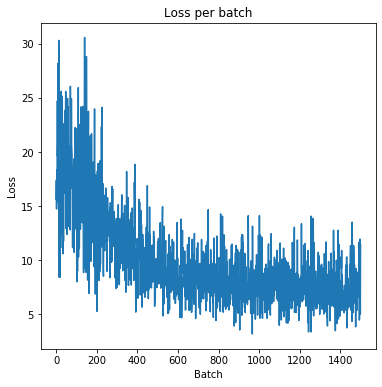

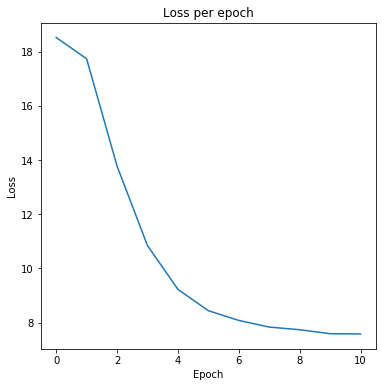

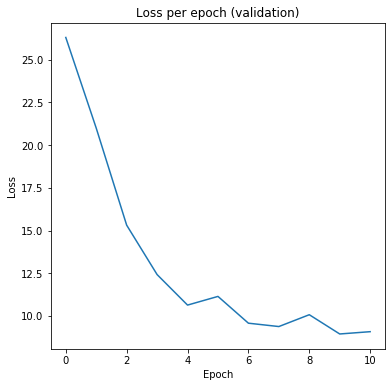

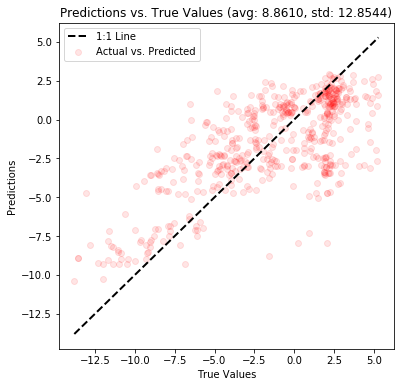

Mean loss: 8.861025535068181, std loss: 12.85444454795249


 --- SWEEP POINT 2/150: (1, 1, 1, 1) ---
 --- time reamining: 06:49:44.94 

Epoch [0/10], Loss epoch: 21.8575, Loss validation: 33.8216
	 Validation string, 	 i: 27; 	 prediction: 0.2324, 	 target: 0.3300, 	 loss: 0.0095
	 Validation string, 	 i: 35; 	 prediction: -1.0160, 	 target: -2.1400, 	 loss: 1.2635
	 Validation string, 	 i: 33; 	 prediction: -0.9802, 	 target: -1.3000, 	 loss: 0.1023
Epoch [1/10], Loss epoch: 18.5250, Loss validation: 21.4392, Time remaining: ~0.0h 5.0m 26s
	 Validation string, 	 i: 33; 	 prediction: -1.2900, 	 target: -1.3000, 	 loss: 0.0001
	 Validation string, 	 i: 0; 	 prediction: -1.6259, 	 target: -1.4000, 	 loss: 0.0510
	 Validation string, 	 i: 42; 	 prediction: -3.2641, 	 target: -11.6800, 	 loss: 70.8275
Epoch [2/10], Loss epoch: 13.4825, Loss validation: 15.6903, Time remaining: ~0.0h 4.0m 30s
	 Validation string, 	 i: 12; 	 prediction: -2.1227, 	 target: -3.9300, 	 loss: 3.2662
	 Validation

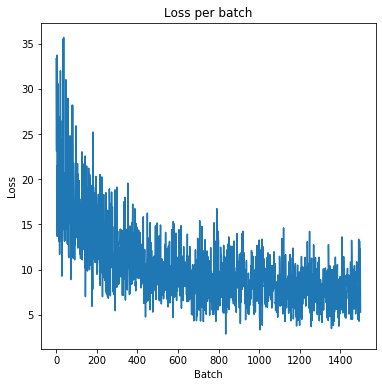

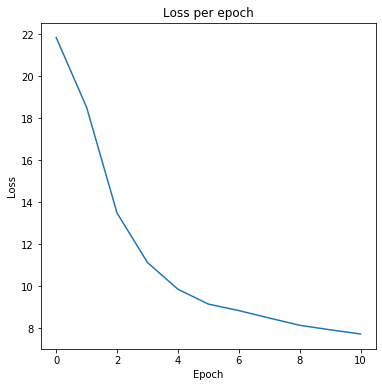

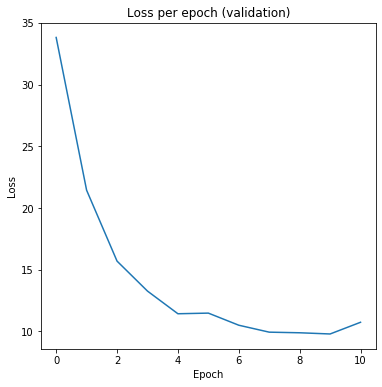

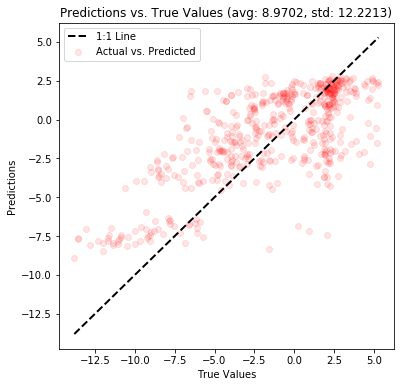

Mean loss: 8.970168347203902, std loss: 12.221277077674523


 --- SWEEP POINT 3/150: (1, 1, 1, 2) ---
 --- time reamining: 09:57:49.24 

Epoch [0/10], Loss epoch: 23.0540, Loss validation: 35.9368
	 Validation string, 	 i: 15; 	 prediction: -1.3629, 	 target: 1.4200, 	 loss: 7.7448
	 Validation string, 	 i: 48; 	 prediction: -1.2166, 	 target: -8.6300, 	 loss: 54.9582
	 Validation string, 	 i: 42; 	 prediction: -1.4882, 	 target: -11.6800, 	 loss: 103.8729
Epoch [1/10], Loss epoch: 18.5477, Loss validation: 21.9373, Time remaining: ~0.0h 7.0m 57s


In [7]:
for sweep_point in sweep.points_left:

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- QUANTUM BLOCK -- #
    n_qubits = 4
    quantum_layer = q.circuit(
        n_qubits = n_qubits, 
        device = "default.qubit.torch",
        device_options = {'shots': None},
        embedding = q.parts.AngleEmbedding, 
        embedding_ansatz = q.parts.Ansatz_11,
        block_ansatz = q.parts.Ansatz_11,
        final_ansatz = q.parts.Ansatz_11, # TODO CHECK IF THIS IS THE BEST OPTION
        measurement = q.parts.Measurement('Z', sweep_point['quantum_measurement']),
        embedding_n_layers = sweep_point['embedding_n_layers'],
        different_inputs_per_layer = False,
        block_n_layers = sweep_point['quantum_n_layers'],
        # wrapper_qlayer = pw.QLayerEmpty,
    )

    # -- MODEL -- #                    
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=1)
            self.fc2 = m.Reshape()
            self.fc3 = quantum_layer()     
            if sweep_point['quantum_measurement'] == 'all':     
                self.fc4 = m.nn.Linear(n_qubits, 1)
            else:
                self.fc4 = m.nn.Linear(1, 1)

        def forward(self, x):
            for i in range(1,5):
                x = getattr(self, 'fc{}'.format(i))(x)
            return x

    model = Model()

    # set quantum layer
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 4 amino acids and 4 qubits using Angle Encoding (repeating embedding) and classical Embedding',    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PE_SCORES_4_Numbers'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 10,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 3, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {}
    )

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        n_parameters=model.n_parameters,
        time_train=model.results.time_epoch.last,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    